In [1]:
h='localhost'
u='root'
pw='password'

import mysql.connector

mydb = mysql.connector.connect(host=h,user=u, password=pw)

In [2]:
# make test database

mycursor = mydb.cursor()
#check if database exits (if it does run 'drop database test' instead)

mycursor.execute("SHOW DATABASES")

for x in mycursor:
    print(x)


('information_schema',)
('mysql',)
('performance_schema',)
('sys',)
('TESS_South',)
('test',)


# Let's try making a database for ecliptic longitudes and latitudes to filter

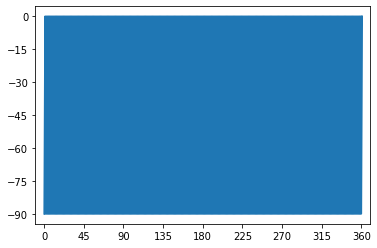

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
def SouthernHemisphere():
    #1st create southern hemisphere
    ECLONGS=[]
    ECLATS =[]
    for x in range(360+1):
        eclong = np.linspace(x,x+1,100)
        eclat = np.linspace(-90,0,100)
        ECLONGS=np.append(ECLONGS,eclong)
        ECLATS=np.append(ECLATS,eclat)    
        
        data=pd.DataFrame({'eclong':ECLONGS,'eclat':ECLATS})
    return data

data = SouthernHemisphere()

plt.plot(data['eclong'],data['eclat'])
plt.xlim(-10,370)
plt.xticks(np.arange(0,360+45,45))
plt.yticks(np.arange(-90,0+15,15))
plt.savefig('SouthernHemisphere.png')
plt.show()

#save data as csv file
data.to_csv('SouthernHemisphere.csv')

In [4]:
mydb = mysql.connector.connect(host=h, user=u, password=pw)
mycursor = mydb.cursor()

# mycursor.execute("drop DATABASE TESSSouth")
# mycursor.execute("create DATABASE TESSSouth")
mycursor.execute("SHOW DATABASES")

for x in mycursor:
    print(x)

('information_schema',)
('mysql',)
('performance_schema',)
('sys',)
('TESS_South',)
('test',)


In [5]:
# mydb = mysql.connector.connect(host=h, user=u, password=pw,database="TESSSouth", allow_local_infile=True)
# mycursor = mydb.cursor()
# #make table with id, eclong, eclat in coordinates table
# sql="CREATE TABLE coordinates (id INT NOT NULL AUTO_INCREMENT, eclong VARCHAR(255) NOT NULL, eclat VARCHAR(255) NOT NULL, PRIMARY KEY (id));"

# mycursor.execute(sql)

In [6]:
from mysql.connector.constants import ClientFlag
mydb = mysql.connector.connect(host=h, user=u, password=pw, database="TESS_South", allow_local_infile=True, client_flags=[ClientFlag.LOCAL_FILES])
mycursor = mydb.cursor()
mycursor.execute("show tables")
for x in mycursor:
    print(x)

('coords',)


In [7]:
data

,eclong,eclat
0,0.000000,-90.000000
1,0.010101,-89.090909
2,0.020202,-88.181818
3,0.030303,-87.272727
4,0.040404,-86.363636
...,...,...
36095,360.959596,-3.636364
36096,360.969697,-2.727273
36097,360.979798,-1.818182
36098,360.989899,-0.909091


In [8]:
# mydb = mysql.connector.connect(host=h, user=u, password=pw, database="TESS_South", allow_local_infile=True)#, client_flags=[ClientFlag.LOCAL_FILES])
# cursor = mydb.cursor()

# import os
# filepath=os.getcwd()+'/SouthernHemisphere.csv'


# # Now load csv into sql table
# LoadSQL = """LOAD DATA LOCAL INFILE '%s'
#     INTO TABLE %s
#     FIELDS TERMINATED BY ',' ENCLOSED BY '"'
#     LINES TERMINATED BY '\r\n'
#     IGNORE 1 LINES;
#     (id, eclong, eclat)""" % (filepath, 'coordinates')

# cursor.execute(LoadSQL)
# mydb.commit()
# cursor.close()
# mydb.close()

In [9]:
# config = {
#     'user': u,
#     'password': pw,
#     'host': h,
#     'buffered': True,
#     'allow_local_infile':True,
#     'client_flags': [ClientFlag.SSL]
# }



# mydb = mysql.connector.connect(**config)
# mycursor = mydb.cursor()
# mycursor.execute("drop DATABASE TESSSouth")
# mycursor.execute("create DATABASE TESS_South")
# mycursor.execute("use TESS_South")
# mycursor.execute("create table coords (id char(13), eclong decimal(12,8), eclat decimal(12,8));")


In [10]:
# import mysql.connector
# from mysql.connector.constants import ClientFlag

# config = {
#     'user': u,
#     'password': pw,
#     'host': h,
#     'database': 'TESS_South',
#     'buffered': True,
#     'allow_local_infile':True,
#     'client_flags': [ClientFlag.SSL]
# }



# mydb = mysql.connector.connect(**config)
# cursor = mydb.cursor()
# cursor.execute('set global local_infile=1')

# import os
# filepath=os.getcwd()+'/SouthernHemisphere.csv'

# # Now load csv into sql table
# LoadSQL = "load data local infile '"+str(filepath)+"' into table coords fields terminated by ',' (id,eclong,eclat);"

# cursor.execute(LoadSQL)
# mydb.commit()
# cursor.close()
# mydb.close()

# Now that we uploaded our simulated darta to mysql, let's see if we can properly filter by sector

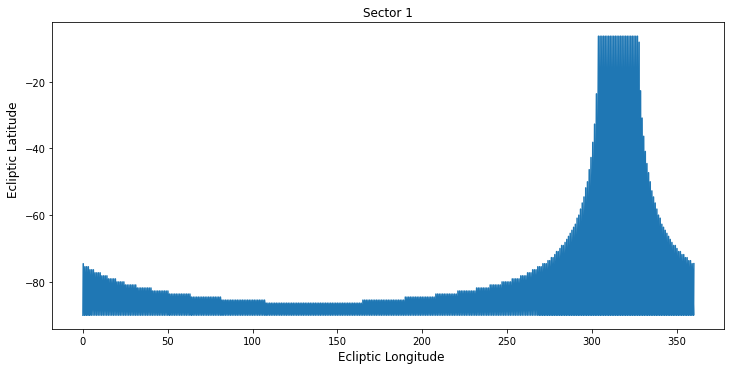

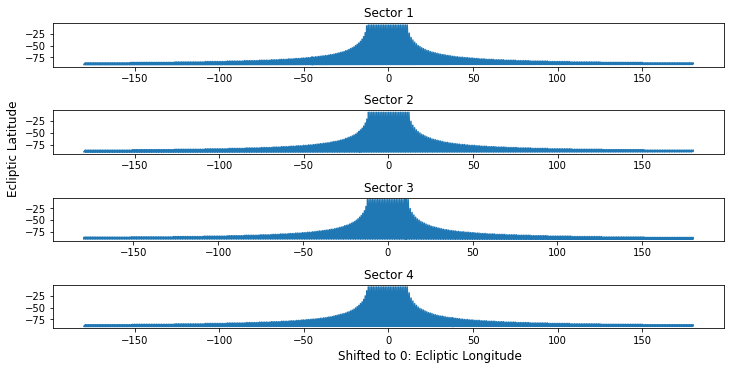

In [18]:
#This is what the filtered sectors should look like:

def SectorBounds_shift(Sector):
    #1st create southern hemisphere
    ECLONGS=[]
    ECLATS =[]
    for x in range(360+1):
        eclong = np.linspace(x,x+1,100)
        eclat = np.linspace(-90,0,100)
        ECLONGS=np.append(ECLONGS,eclong)
        ECLATS=np.append(ECLATS,eclat)    
    #then store in dataframe
    simDF=pd.DataFrame({"eclong":ECLONGS,"eclat":ECLATS})    
    
    #then make sky cut depending on Sector
    #these are central ecliptic longitude pointings for S1 - S13
    ctr_eclongs = [315.8,343,10.94,38.48,65.85,92.85,119.738980,146.15,172.28,198.72,225.93,253.56,281.12]
    
    Sector_ind=Sector-1 #zero indexing
    
    x = np.array(np.remainder(simDF['eclong']+360-ctr_eclongs[Sector_ind],360)) # shift lon values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    
#     cut = (x < 12/np.cos(simDF['eclat']*np.pi/180)) & (-12/np.cos(simDF['eclat']*np.pi/180) < x)
    cut = np.abs(x) < 12/np.cos(simDF['eclat']*np.pi/180)
    cutDF = simDF.loc[(simDF['eclat'] < -6) & (cut) ]
    
    return cutDF


S1 = SectorBounds_shift(1)
S2 = SectorBounds_shift(2)
S3 = SectorBounds_shift(3)
S4 = SectorBounds_shift(4)

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(111)
# ax2=fig.add_subplot(412)
# ax3=fig.add_subplot(413)
# ax4=fig.add_subplot(414)

ax1.set_title('Sector 1')
ax1.plot(S1['eclong'],S1['eclat'])
# ax2.plot(S2['eclong'],S2['eclat'])
# ax3.plot(S3['eclong'],S3['eclat'])
# ax4.plot(S4['eclong'],S4['eclat'])

fig.text(0.45,-0.01,'Ecliptic Longitude',fontsize=12)
fig.text(-0.01,0.45,'Ecliptic Latitude',rotation=90,fontsize=12)
fig.tight_layout(pad=1)
fig.savefig('Sector1_bounds.png',bbox_inches='tight')
plt.show()


#shifting central longitude to 0 for easier visualization
def shift_lon_get_x(lon, origin):
    x = np.array(np.remainder(lon+360-origin,360)) # shift lon values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    return x

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(411)
ax2=fig.add_subplot(412)
ax3=fig.add_subplot(413)
ax4=fig.add_subplot(414)


ax1.plot(shift_lon_get_x(S1['eclong'], 315),S1['eclat'])
ax2.plot(shift_lon_get_x(S2['eclong'], 343),S2['eclat'])
ax3.plot(shift_lon_get_x(S3['eclong'], 10.94),S3['eclat'])
ax4.plot(shift_lon_get_x(S4['eclong'], 38),S4['eclat'])

ax1.set_title('Sector 1')
ax2.set_title('Sector 2')
ax3.set_title('Sector 3')
ax4.set_title('Sector 4')

fig.text(0.45,-0.01,'Shifted to 0: Ecliptic Longitude',fontsize=12)
fig.text(-0.01,0.45,'Ecliptic Latitude',rotation=90,fontsize=12)
fig.tight_layout()
plt.show()

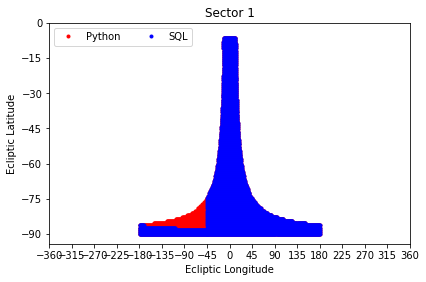

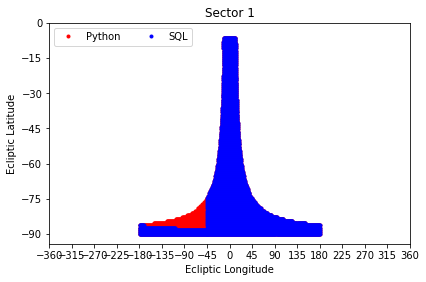

In [20]:
import mysql.connector
from mysql.connector.constants import ClientFlag
import pandas as pd

config = {
    'user': u,
    'password': pw,
    'host': h,
    'database': 'TESS_South',
    'buffered': True,
    'allow_local_infile':True,
    'client_flags': [ClientFlag.SSL]
}



mydb = mysql.connector.connect(**config)
cursor = mydb.cursor()

#Sector 1
# query = "select * from coords where eclat < -6 and mod(abs(eclong+360-315.8),360) < 180 and mod(abs(eclong+360-315.8),360) < 12/cos(radians(eclat));"
# query = "select * from coords where eclat < -6 and mod(abs(eclong-315.8+360),360)-360 < 180 and mod(abs(eclong-315.8),360) < 12/cos(radians(eclat));"

query = """select * from coords
    where eclat < -6
    and mod(abs(eclong-315.8+360),360)-360 < 180
    and mod(abs(eclong-315.8),360) < 12/cos(radians(eclat))
    """


cursor.execute(query)
import csv
rows = cursor.fetchall()
headers = [col[0] for col in cursor.description] # get headers
fp = open('filter1.csv', 'w')
myFile = csv.writer(fp)
myFile.writerow(headers)
myFile.writerows(rows)
fp.close()

filter1=pd.read_csv('filter1.csv')
plt.plot(shift_lon_get_x(S1['eclong'],315.8),S1['eclat'],'r.',label='Python')
plt.plot(shift_lon_get_x(filter1['eclong'],315.8),filter1['eclat'],'b.',label='SQL')
# plt.xlim(-10,370)
# plt.ylim(-100,10)
plt.xticks(np.arange(0-360,360+45,45))
plt.yticks(np.arange(-90,0+15,15))
plt.title('Sector 1')
plt.xlabel('Ecliptic Longitude')
plt.ylabel('Ecliptic Latitude')
plt.legend(loc='upper left',ncol=2)
plt.tight_layout(pad=1)
plt.savefig('SQL_vs_Python_query_S1.png',bbox_inches='tight')
plt.show()



#returns same results as above
query = """select * from coords
    where eclat < -6
    and mod(abs((eclong-315.8)),360) < 12/cos(radians(eclat))
    """


cursor.execute(query)
import csv
rows = cursor.fetchall()
headers = [col[0] for col in cursor.description] # get headers
fp = open('filter1.csv', 'w')
myFile = csv.writer(fp)
myFile.writerow(headers)
myFile.writerows(rows)
fp.close()

filter1=pd.read_csv('filter1.csv')
plt.plot(shift_lon_get_x(S1['eclong'],315.8),S1['eclat'],'r.',label='Python')
plt.plot(shift_lon_get_x(filter1['eclong'],315.8),filter1['eclat'],'b.',label='SQL')
# plt.xlim(-10,370)
# plt.ylim(-100,10)
plt.title('Sector 1')
plt.xticks(np.arange(0-360,360+45,45))
plt.yticks(np.arange(-90,0+15,15))
plt.xlabel('Ecliptic Longitude')
plt.ylabel('Ecliptic Latitude')
plt.legend(loc='upper left',ncol=2)
plt.tight_layout(pad=1)
plt.savefig('SQL_vs_Python_query_S1.png',bbox_inches='tight')
plt.show()

In [16]:
import mysql.connector
from mysql.connector.constants import ClientFlag

config = {
    'user': u,
    'password': pw,
    'host': h,
    'database': 'TESS_South',
    'buffered': True,
    'allow_local_infile':True,
    'client_flags': [ClientFlag.SSL]
}



mydb = mysql.connector.connect(**config)
cursor = mydb.cursor()

#Sector 1
query = """select * from coords
    where eclat < -6
    and mod(abs(eclong-315.8+360),360)-360 < 180
    and mod(abs(eclong-315.8),360) < 12/cos(radians(eclat))
    """
#try a case statement
query = """select * from coords,
    case 
    when eclat < -6 then eclong-360
    else eclong
    end as good_eclong
    from 'eclong'"""


cursor.execute(query)
import csv
rows = cursor.fetchall()
headers = [col[0] for col in cursor.description] # get headers
fp = open('filter2.csv', 'w')
myFile = csv.writer(fp)
myFile.writerow(headers)
myFile.writerows(rows)
fp.close()

filter1=pd.read_csv('filter2.csv')
plt.plot(shift_lon_get_x(S1['eclong'], 315),S1['eclat'],'r.')
plt.plot(shift_lon_get_x(filter1['eclong'], 315),filter1['eclat'],'b.')
# plt.xlim(-10,370)
plt.xlim(-190,190)
plt.ylim(-100,10)
plt.xticks(np.arange(-180,180+45,45))
plt.yticks(np.arange(-90,0+15,15))
plt.show()

ProgrammingError: 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'case 
    when eclat < -6 then eclong-360
    else eclong
    end as good_eclong' at line 2

In [ ]:
(eclat < -6 and mod(abs(eclong-315.8+360),360)-360 < 180 and mod(abs(eclong-315.8),360) < 12/cos(radians(eclat)))